*sklearn.ensemble.HistgradientBoostingClassifer.fit(test_X (n_samples, n_features), true_y (n_samples, ), sample_weight)*

1. Run Throguh all proton, pion data, merge them (Just Tack on pion 2D array unto protons)
    - Create Target values using par label (Binarize this time)
2. Run decided identifying stats/attributes on merged test set, creating new entries in the dataset ak.record
    - Attributes will be in 1D arrays (Event level Analysis), coalesce them by column to create input test_X
3. Run fitting method on generated HistGradientBoostingClassifier object
    - Run Score method on test data
    - Metabagging?
4. Run ROCKdat function with predict.proba(X) as the y_score in metrics.roc_curve
5. Finito :)

---------------------------------------------------------------------
- HyperParameter Optimization? 
- Recoil Tracker Lower Threshhold Optimization?

In [3]:
from coffea import hist
import math
from time import process_time
import os
import psutil
import uproot
import awkward as ak
from sklearn.neighbors import KernelDensity
from scipy.stats import moyal
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [4]:
with uproot.open("data/protonpion_Oct5/ntuple_gps_proton_100.00-2000.00MeV_50k_target_events_r0007_b2_104.root") as file:
    print(file["Events"].keys())
    print(file["Events"]["Ecal_SimHit_edep"].array())

['n_Sim_Particle', 'Sim_Particle_pdgID', 'Sim_Particle_trkID', 'Sim_Particle_mass', 'Sim_Particle_e', 'Sim_Particle_kine', 'Sim_Particle_vx', 'Sim_Particle_vy', 'Sim_Particle_vz', 'Sim_Particle_endx', 'Sim_Particle_endy', 'Sim_Particle_endz', 'Sim_Particle_px', 'Sim_Particle_py', 'Sim_Particle_pz', 'n_Recoil_SimHit', 'Recoil_SimHit_x', 'Recoil_SimHit_y', 'Recoil_SimHit_z', 'Recoil_SimHit_px', 'Recoil_SimHit_py', 'Recoil_SimHit_pz', 'Recoil_SimHit_pdgid', 'Recoil_SimHit_edep', 'Recoil_SimHit_pathLength', 'Recoil_SimHit_layer', 'n_Ecal_SimHit', 'Ecal_SimHit_edep', 'Ecal_SimHit_t', 'Ecal_SimHit_x', 'Ecal_SimHit_y', 'Ecal_SimHit_z', 'Ecal_SimHit_layer', 'n_Ecal_RecHit', 'Ecal_RecHit_amp', 'Ecal_RecHit_e', 'Ecal_RecHit_t', 'Ecal_RecHit_x', 'Ecal_RecHit_y', 'Ecal_RecHit_z', 'Ecal_RecHit_layer']
[[0.00793], [], [], [], [0.0236], [0.0226, ... [], [], [0.00883], [], [], []]


In [5]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x


#Take the difference between consecutive measurements
def infinitesimalish(arr, lead=0):
    rtn=[]
    for evt in arr:
        evtArr=[]
        prev=evt[0]
        for hit in evt:
            evtArr.append(prev-hit)
            prev=hit
        
        evtArr[0]=lead
        rtn.append(evtArr)
    return ak.Array(rtn)

#Adds angle key:value entry to arr (Usually ldmx_events), using above method and LorentzVector class from coffea
def add_angle(arr):
    part=get_vector(arr)
    arr["theta"] = part.theta*(180/np.pi)
    return 

def add_angle_rTracker(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    },
                    with_name="ThreeVector")
    
    arr["theta"] = part.theta*(180/np.pi)
    
def add_momentum(arr):
    rho = np.sqrt(arr.px**2+arr.py**2+arr.pz**2)
    arr["momentum"] = rho
    return

#Returns ak.Record with coffea.LorentzVector behavior
def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part 
    
def cvBand(arr): 
    if len(arr)==1:
        return 1000
    elif len(arr)<5:
        cross=len(arr)
    else:
        cross=5
        
    bandwidths =np.linspace(0, 2, 100)
    grid = GridSearchCV(KernelDensity(kernel=kernel),
                    {'bandwidth': bandwidths},
                    cv=cross)
    bndwth=grid.fit(arr[:, None])
    best=bndwth.best_params_['bandwidth']
    return best

#best=cvBand(evt.edep)
#if best==1000:
    #match[spot]=evt.edep[0]
    #spot+=1
    #continue
        
def kernelDensity(arr):
    match=np.zeros(ak.num(arr, axis=0))
    spot=0
    for evt in arr:
        if len(evt)==1:
            match[spot]=evt[0]
            spot+=1
            continue
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(evt[:, np.newaxis])
        dens = np.exp(kde.score_samples(evt[:, np.newaxis]))
        mostLikely=max(dens)
        for i in range(len(dens)):
            if dens[i]==mostLikely: 
                match[spot]=evt[i]
                break
        spot+=1
    
    return match

In [6]:
def AssembleTestSet(chunk):
    ldmx_events = repackage(chunk)
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']

    #Determines if data file is one for protons or pions
    par=""
    ID=0
    restMass=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
        restMass=938.27208816
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
        restMass=139.57039

    #Removes empty events. There are a lot of empty events. 
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask | ecalRecEmptyMask]
    ecal_rechit=ecal_rechit[recoilEmptyMask | ecalRecEmptyMask]
    #There are on Average ~38000 Empty Events in the ecal and the recoil and ~28000 that are empty in both
    #print(ak.num(ldmx_events["Ecal_RecHit"], axis=0)-ak.num((ldmx_events["Ecal_RecHit"])[recoilEmptyMask & ecalRecEmptyMask], axis=0))
    
    #Add dedz to Rechits
    ecalRecWidths=[2.5,1.5,1.25,3,2.75,4.5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,8.5,7,8.5,7,8.5,7,8.5,7,8.5,7]
    widthMap=[[ecalRecWidths[hit] for hit in evt] for evt in ecal_rechit.layer]
    widthMap=ak.Array(widthMap)
    ecal_rechit["edep"]=ecal_rechit.e/widthMap
    
    #-------------------------------------Start Event Level Analysis-----------------------------------------
    #For Recoil Tracker- RecAvg, RecMP, RecSumEShw
    #For Ecal- EcalAvg, EcalMp, EcalSumEShw, EcalShwWth
    #Of a particular importance here is to use ak.mask, as even events which disappear once a MIP requirement is added need 
    #to be matched up with events from the recoil tracker. Regular masking will lead to 2 different length records and not 
    #represent the actual data. For those Events which have Zero (0) features, they will be counted but removed from the training data. 
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #MIP Masks
    recoilMIPMask=recoil_simhit.edep>=.13
    ecalRecMIPMask=ecal_rechit.e>=.13
    
    #---------------Recoil Tracker
    twoDMask= recoilIDMask #& recoilMIPMask 
    emptiesIncluded=recoil_simhit[twoDMask]
    #Apply the emptyMask with ak.mask, so that the 1D data alignment is preserved. If you wished to preserve the 
    #2d alignment, you would apply the 2d mask with ak.mask as well. 
    emptiesMask=ak.num(emptiesIncluded)>0 
    noEmpties=ak.mask(emptiesIncluded, emptiesMask)
    
    
    #Fills Energy Average and Energy Sum
    edepSum=ak.sum(noEmpties.edep, axis=1)
    edepAvg=ak.mean(noEmpties.edep, axis=1)
    #First declaration of recoil analyses record
    RecAttrs=ak.zip({"RecAvg":edepAvg})
    RecAttrs["Kine"]=ak.flatten((sim_particle[recoilEmptyMask | ecalRecEmptyMask]).kine, axis=None)
    
    #Fills Most Probable Energy Loss 
    RecMP=ak.Array([moyal.fit(s[0])[0] if ak.num(s, axis=0)!=0 else None for s in ak.singletons(noEmpties.edep)])
    RecAttrs["RecMP"]=RecMP
    
    #Fills Sum Energy Over Z to Shower Max
    showerMax=np.zeros(len(noEmpties))
    spot=0
    for evt in noEmpties:
        #print(evt, [evt])
        if ak.num([evt], axis=1)[0]==None:
            showerMax[spot]=None
            spot+=1
            continue
        mx=max(evt.edep)
        for hit in evt:
            if hit.edep==mx:
                R=np.sqrt((hit.z)**2+(hit.x)**2+(hit.y)**2)
                showerMax[spot]=R
        spot+=1

    RecSumEShw=edepSum/showerMax
    RecAttrs["RecSumEShw"]=RecSumEShw
    
    #Fills NumHits
    dropLow=noEmpties[noEmpties.edep>=.17]
    dropLow=ak.mask(dropLow, ak.num(dropLow)>0)
    hits=ak.num(dropLow.edep, axis=1)
    RecAttrs["RecHits"]=hits
    
    print("Recoil Done")
    
    #---------------Ecal_RecHits
    twoDMask=ecalRecMIPMask
    emptiesIncluded=ecal_rechit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    noEmpties=ak.mask(emptiesIncluded, emptiesMask)
    
    #Fills  Average dedz 
    sumdedz=ak.mean(noEmpties.edep, axis=1)
    avgdedz=ak.mean(noEmpties.edep, axis=1)
    #First declaration of ecal analyses record
    EcalAttrs=ak.zip({"EcaAvg":avgdedz})
    
    #Fills Shower RMS Width
    weight=np.log(noEmpties.edep)
    centerX=ak.mean(weight*noEmpties.x, axis=1)
    centerY=ak.mean(weight*noEmpties.y, axis=1)

    R2=(weight*(noEmpties.x-centerX))**2+(weight*(noEmpties.y-centerY))**2
    rms=np.sqrt(ak.mean(R2, axis=1))
    EcaShwWdth=rms
    EcalAttrs["EcaShwWdth"]=EcaShwWdth
    
    #Fills Most Probable Energy Loss
    EcaMP=ak.Array([moyal.fit(s[0])[0] if ak.num(s, axis=0)!=0 else None for s in ak.singletons(noEmpties.edep)])
    EcalAttrs["EcaMP"]=EcaMP
    
    #Fills Sum Energy over Z to Shower Max
    showerMax=np.zeros(len(noEmpties))
    spot=0
    for evt in noEmpties:
        if ak.num([evt], axis=1)[0]==None:
            showerMax[spot]=None
            spot+=1
            continue
        mx=max(evt.edep)
        for hit in evt:
            if hit.edep==mx:
                R=np.sqrt((hit.z-240)**2+(hit.x)**2+(hit.y)**2)
                showerMax[spot]=R
        spot+=1   
        
    EcaSumEShw=sumdedz/(showerMax)#-240)
    EcalAttrs["EcaSumEShw"]=EcaSumEShw
    
    print("Ecal Done")    
        
    #--------------------------------Fill global dictionary-----------------------------------
    for attr in testData[par].keys():
        if attr[0:3]=="Eca":
            testData[par][attr].append(getattr(EcalAttrs, attr))
        else:
            testData[par][attr].append(getattr(RecAttrs, attr))
        
    #elif par=="Pion":
    #    for attr in testData["PionsRecoil"].keys():
    #        testData["PionsRecoil"][attr].append(getattr(recoil_simhit, attr))
    #        testData["PionsEcal"][attr].append(getattr(ecal_rechit, attr))
    #    testData["PionsEcal"]["e"].append(getattr(ecal_rechit, "e"))



In [7]:
#Temporary Dictionaries to be converted to ak.record. Edep will hold dedz for the Ecal, as EcalRecHits dedz \
#is treated in all calculations as the Ecal_RecHit's "Edep" 
testData={"Proton":{'Kine':[], 'RecAvg':[], 'RecMP':[], 'RecSumEShw':[], #'RecHits':[],
                    'EcaAvg':[], 'EcaMP':[], 'EcaSumEShw':[], 'EcaShwWdth':[]},
          "Pion":  {'Kine':[], 'RecAvg':[], 'RecMP':[], 'RecSumEShw':[], #'RecHits':[],
                    'EcaAvg':[], 'EcaMP':[], 'EcaSumEShw':[], 'EcaShwWdth':[]}}
                       
ldmx_dict_all = getData(chunks=True, fnames="data/protonpion_Oct5/*.root")
print(ldmx_dict_all)
    
#Loop Through all Files and Add Them to testData
#Small loop to extract events into Proton/PionHolder
start=process_time()
nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    AssembleTestSet(chunk)

stop=process_time()
print("Time to analyze all data is: {}".format((stop-start)/60))


<generator object iterate at 0x000001ABB0D16200>
process 1


C:\Users\Acer\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1833: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
C:\Users\Acer\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6005: RuntimeWarning: overflow encountered in exp
  return np.exp(-0.5 * (x + np.exp(-x))) / np.sqrt(2*np.pi)


Recoil Done
Ecal Done
process 2
Recoil Done
Ecal Done
process 3
Recoil Done
Ecal Done
process 4
Recoil Done
Ecal Done
process 5
Recoil Done
Ecal Done
process 6
Recoil Done
Ecal Done
Time to analyze all data is: 36.365885416666664


In [8]:
#Copying For now so no rerun required
import copy
testDataCopy=copy.deepcopy(testData)
testDataCopyBinary={}

#------------------Clean Up Data From Dictionary-------------------
X={}
true={}
for coll in testDataCopy:
    for attr in testDataCopy[coll].keys():
        testDataCopy[coll][attr]=ak.Array(ak.fill_none(ak.flatten(testDataCopy[coll][attr], axis=1), -1, axis=-1))
        
    testDataCopy[coll]=ak.zip(testDataCopy[coll])
    if coll=="Proton":
        testDataCopyBinary[coll]=ak.ones_like(testDataCopy[coll])
    else: 
        testDataCopyBinary[coll]=ak.zeros_like(testDataCopy[coll])


#---------------Organize X and true---------------------------------
#First create (n_samples, nfeatures) then merge
first=True
for coll in testDataCopy:
    for attr in testDataCopy[coll].fields:
        if first==True:
            X[coll]=testDataCopy[coll][attr][:, np.newaxis]
            true[coll]=testDataCopyBinary[coll][attr]
            first=False
            continue
        
        X[coll]=ak.concatenate([X[coll], testDataCopy[coll][attr][:, np.newaxis]], axis=1)
        
    first=True

#Final Merge
X=ak.concatenate([X["Proton"], X["Pion"]], axis=0)
true=ak.concatenate([true["Proton"], true["Pion"]], axis=0)

In [9]:
#-----------------Now we train the BDT-------------------------------------------------
#Remove Kinetic energies, lest we wish to bias the BDT
noKineX=X[:, 1:]

#Get rid of events which don't have any statistics. This is the case if an event was lost due to MIP imposition
noKineX=noKineX[ak.any(noKineX!=-1, axis=1)] 
true=true[ak.any(noKineX!=-1, axis=1)]

#Take half the data to train the BDT, the other half to test
train=[True if i%2==0 else False for i, x in enumerate(noKineX, 1)]
test=[True if i%2==1 else False for i, x in enumerate(noKineX, 1)]

#Create BDT object
clf=GradientBoostingClassifier(loss="deviance", n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=1)\
                                .fit(noKineX[train], true[train])
print(clf.score(noKineX[test], true[test]))
print(clf.feature_importances_)

#Notes on Hyper parameters, will soon develop a CV for them
#.627 for max_depth=5, .625 for max_depth=3, 10
#for AdaBoost, max depth=5 improves to .629



0.6213958460598656
[0.33081801 0.16850951 0.13124065 0.04345578 0.20331893 0.07126576
 0.05139135]


In [10]:
#------------------Masks for Test Data--------------------------------------------------
protons= true==1
pions= true==0
ghostMask= ak.any(noKineX!=-1, axis=1) #Gets rid of events which don't have any statistics
bothMask= ak.all(noKineX!=-1, axis=1) #Only events with both Ecal and recoil hits
ecalMask= ak.all(noKineX[:,:3]==-1, axis=1) #Only Ecal hit Events
recoilMask= ak.all(noKineX[:,3:]==-1, axis=1) #Only recoil hit Events

#-----------------Train a BDT with Normalized events between Recoil and Ecal------------
def normRecoilEcal(X, y):
    protons= y==1
    pions= y==0
    nData=[]
    nTrue=[]
    for i in range(3):
        if i==0:
            mask= ak.all(X[:,3:]==-1, axis=1) #Only recoil hit Events
        elif i==1:
            mask= ak.all(X[:,:3]==-1, axis=1) #Only Ecal hit Events
        else:
            mask= ak.all(X!=-1, axis=1) #Only events with both Ecal and recoil hits

        pro=X[mask & protons]
        pio=X[mask & pions]
        lesser=min(len(pro), len(pio))
        nData.append(pro[:lesser])
        nData.append(pio[:lesser])
        nTrue.append(np.ones(lesser))
        nTrue.append(np.zeros(lesser))

    #Numpy and python lists are finnicky
    nData=ak.Array(nData)
    nTrue=ak.Array(nTrue)
    #Equalize number of events for recoil- and ecal-only, and flatten arrays
    lesser=min(ak.num(nData[:4], axis=1))
    nData=[nData[:4, :lesser], nData[4:]]
    nTrue=[nTrue[:4, :lesser], nTrue[4:]]
    nData=ak.flatten(ak.flatten(nData, axis=1), axis=1)
    nTrue=ak.flatten(nTrue, axis=None)

    #Create Training and Testing Masks
    ntrain=ak.Array([True if i%2==0 else False for i, x in enumerate(nData, 1)])
    ntest=ak.Array([True if i%2==1 else False for i, x in enumerate(nData, 1)])
    
    return nData, nTrue, ntrain, ntest
    
#Create BDT object
nData, nTrue, ntrain, ntest=normRecoilEcal(noKineX, true)
nlf=GradientBoostingClassifier(loss="deviance", n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=1)\
                                .fit(nData[ntrain], nTrue[ntrain])
print(nlf.score(nData[ntest], nTrue[ntest]))
print(nlf.feature_importances_)



0.6525635956240938
[0.14012738 0.31172649 0.08355447 0.07553604 0.18679941 0.14013914
 0.06211707]


Text(1, 0, 'FPR')

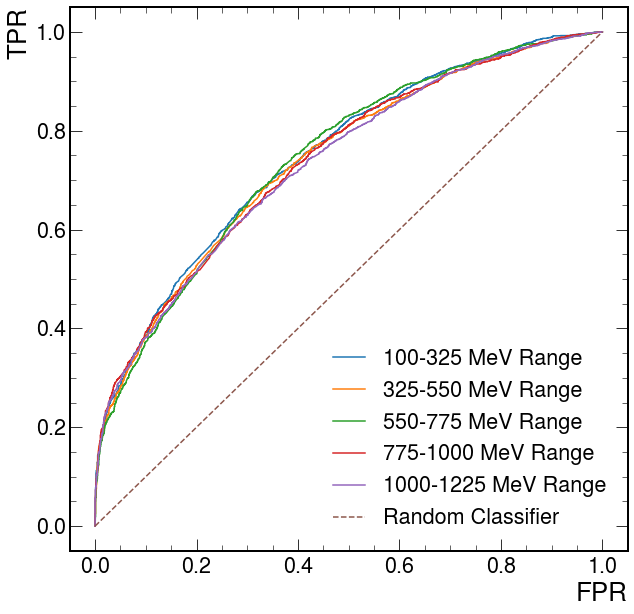

In [11]:
#-----------------Make ROC Curves for Different Kine Ranges-------------------------------
fig, ax=plt.subplots(figsize=(10,10))
for i in np.linspace(100, 1000, 5):
    kineMaskLow=X[:,0]>=i
    kineMaskUpp=X[:,0]<=i+225
    kineMask= kineMaskLow & kineMaskUpp
    kineMask= kineMask[ghostMask]
    
    #For non-normalized Data Set
    '''
    scores=clf.predict_proba(noKineX[kineMask & test])
    fpr, tpr, thresholds=metrics.roc_curve(true[kineMask & test], scores[:,1])
    ax.plot(fpr, tpr, label="{}-{} MeV Range".format(int(i), int(i)+225))
    #'''
    
    #For Normalized Data Set
    #'''
    nData, nTrue, ntrain, ntest=normRecoilEcal(noKineX[kineMask], true[kineMask])
    scores=nlf.predict_proba(nData[ntest])
    fpr, tpr, thresholds=metrics.roc_curve(nTrue[ntest], scores[:,1])
    ax.plot(fpr, tpr, label="{}-{} MeV Range".format(int(i), int(i)+225))
    #'''
    
ax.plot([0,1],[0,1], "--", figure=fig, label="Random Classifier")
ax.legend(loc="lower right")
ax.set_ylabel("TPR")
ax.set_xlabel("FPR")

[0.33081801 0.16850951 0.13124065 0.04345578 0.20331893 0.07126576
 0.05139135]
(4, 50)


Text(1, 0, 'Kinetic Energy [MeV]')

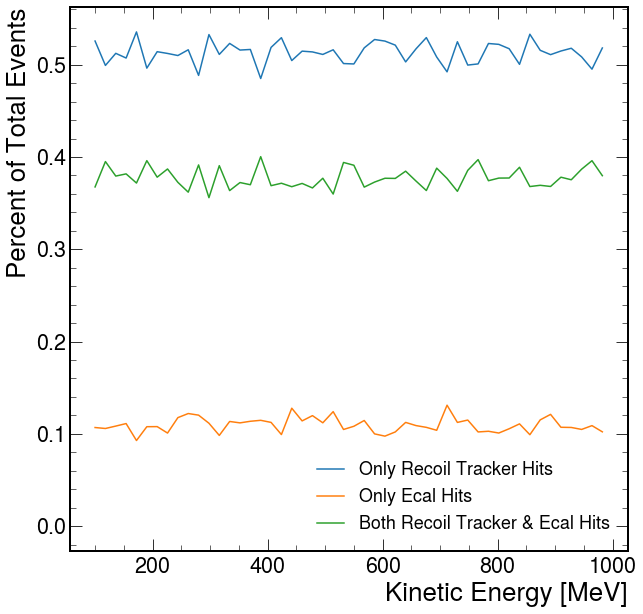

In [12]:
#----------------------Analyzing the BDT for Event Distribution between the Recoil Tracker and Ecal 
print(clf.feature_importances_)

cuts=50
step=900//cuts
Kines=np.linspace(100, 1000-step, cuts)
eventNum=np.zeros((4, cuts))
print(eventNum.shape)
for i in Kines:
    iteration=math.floor((i-100)/step)
    kineMaskLow=X[:,0]>=i
    kineMaskUpp=X[:,0]<=i+step
    kineMask= kineMaskLow & kineMaskUpp
    kineMask= kineMask[ghostMask]
    total=len(noKineX[kineMask])
    
    eventNum[0, iteration]=len(noKineX[kineMask & recoilMask])/total
    eventNum[1, iteration]=len(noKineX[kineMask & ecalMask])/total
    eventNum[2, iteration]=len(noKineX[kineMask & bothMask])/total
    eventNum[3, iteration]=len(noKineX[kineMask])


fig, ax=plt.subplots(figsize=(10,10))
ax.plot(Kines, eventNum[0], label="Only Recoil Tracker Hits")
ax.plot(Kines, eventNum[1], label="Only Ecal Hits")
ax.plot(Kines, eventNum[2], label="Both Recoil Tracker & Ecal Hits")
#ax.plot(Kines, eventNum[3], label="Total")
ax.plot([100,1000-step],[0, 0], 'white')
ax.legend(loc="lower right", fontsize=18)
ax.set_ylabel("Percent of Total Events")
ax.set_xlabel("Kinetic Energy [MeV]")
    

Text(1, 0, 'Kinetic Energy [MeV]')

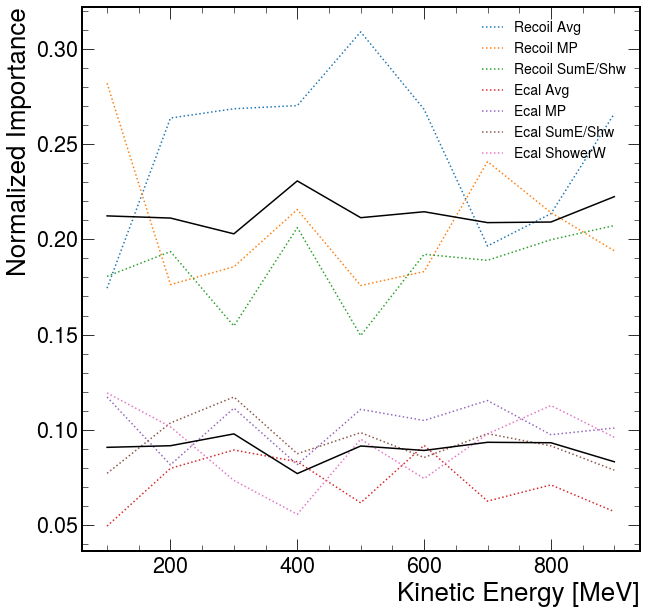

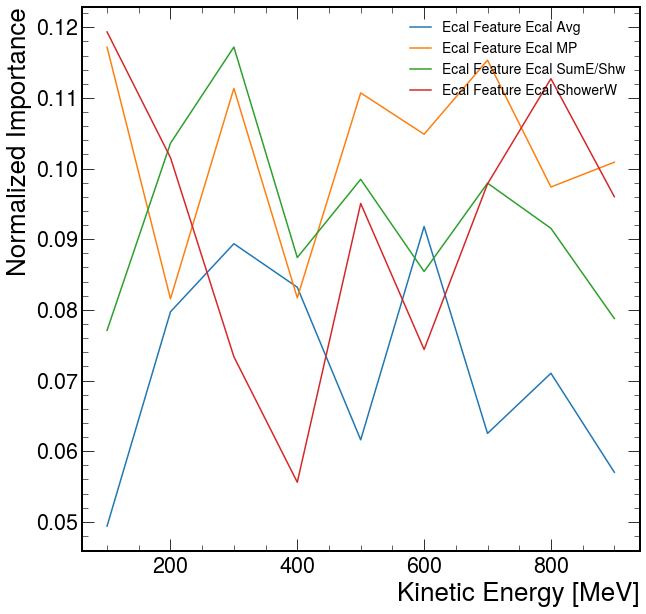

In [13]:
cuts=9
step=900//cuts
featImp=np.zeros((cuts, 7))
accuracies=np.zeros(cuts)
Kines=np.linspace(100, 1000-step, cuts)
for i in Kines:
    iteration=math.floor((i-100)/step)
    kineMaskLow=X[:,0]>=i
    kineMaskUpp=X[:,0]<=i+step
    kineMask= kineMaskLow & kineMaskUpp
    kineMask=kineMask[ghostMask]
    
    
    #'''
    clf=GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_split=10).fit(noKineX[kineMask & train], true[kineMask & train])
    featImp[iteration]=clf.feature_importances_
    accuracies[iteration]=clf.score(noKineX[kineMask & test], true[kineMask & test])
    #'''
    
    '''
    nData, nTrue, ntrain, ntest=normRecoilEcal(noKineX[kineMask & train], true[kineMask & train])
    nlf=GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_split=10).fit(nData[ntrain], nTrue[ntrain])
    featImp[iteration]=nlf.feature_importances_
    accuracies[iteration]=nlf.score(nData[ntest], nTrue[ntest])
    #'''
    
featNames=['Recoil Avg', 'Recoil MP', 'Recoil SumE/Shw', 'Ecal Avg', 'Ecal MP', 'Ecal SumE/Shw', 'Ecal ShowerW']
fig1, ax1=plt.subplots(figsize=(10,10))
for i in range(3):
    ax1.plot(Kines, featImp[:, i], ":", label=featNames[i])
for i in range(3, 7):
    ax1.plot(Kines, featImp[:, i], ":", label=featNames[i])
ax1.plot(Kines, ak.mean(featImp[:, :3], axis=1), color="Black")
ax1.plot(Kines, ak.mean(featImp[:, 3:7], axis=1), color="Black")

ax1.legend(loc="upper right", fontsize=14)
ax1.set_ylabel("Normalized Importance")
ax1.set_xlabel("Kinetic Energy [MeV]")
    
fig2, ax2=plt.subplots(figsize=(10,10))
for i in range(3, 7):
    ax2.plot(Kines, featImp[:, i], label="Ecal Feature {}".format(featNames[i]))
ax2.legend(loc="upper right", fontsize=14)   
ax2.set_ylabel("Normalized Importance")
ax2.set_xlabel("Kinetic Energy [MeV]")



In [14]:
#Generates ROC curves True, Score, and Sample_Weight parameters given 2d histogram arrays for proton and pion. 
#Upper and Lower refer to y axis of the plot.
def ROCKdat(proton, pion):
    arrsize=len(proton)
    bigtrue=np.zeros(int((arrsize)*(arrsize+1)))
    bigscore=np.zeros(int((arrsize)*(arrsize+1)))
    bigweights=np.zeros(int((arrsize)*(arrsize+1)))
    
    proWeights=proton
    pioWeights=pion
    proLabels=parLabel(proton, 2212)
    pioLabels=parLabel(pion, 211)
    
    #Used for determining array indices
    counter=arrsize
    for i in np.arange(0, arrsize):
        y_true=merge(proLabels[i:],pioLabels[i:])
        #Check This
        if (all(proWeights[i:]==0)):
            proton_prob=0.000001
        else:
            proton_prob=np.sum(proWeights[i:])/(np.sum(proWeights[i:])+np.sum(pioWeights[i:]))
        #Produces same Graphs as Scoring Code above
        #proton_prob=(1/arrsize)*i
        y_score=[proton_prob]*(arrsize-i)*2
        weights=merge(proWeights[i:], pioWeights[i:])
        
        n=arrsize-counter
        up=((n+1)*arrsize-(n*(n+1))//2)*2
        lo=up-counter*2
        bigtrue[lo:up]=y_true
        bigscore[lo:up]=y_score
        bigweights[lo:up]=weights
        counter-=1
        
    #print(bigtrue)
    return bigtrue, bigscore, bigweights
                                    
    
#For 2d histogram arrays, the rows are the de/dz, the columns are kine. 
def threeROC(histogram, numROC):#, fig):
    proton=histogram.values()[('Proton',)]
    pion=histogram.values()[('Pion',)]
    kinesize=len(proton)
    step=kinesize/numROC
    ret=np.zeros((numROC, 3, 10000))
    
    spot=0
    for i in np.linspace(step, kinesize, numROC):
        gauss=(kinesize+1)*(kinesize)
        lo=math.floor(i-step)
        up=math.floor(i)
        ytru=np.zeros(gauss*(up-lo))
        ysco=np.zeros(gauss*(up-lo))
        weig=np.zeros(gauss*(up-lo))
        
        for j in range(lo,up):
            lndx=gauss*(j-lo)
            hndx=lndx+gauss
            ytru[lndx:hndx], ysco[lndx:hndx], weig[lndx:hndx]=ROCKdat(np.ndarray.flatten(proton[:, j]), np.ndarray.flatten(pion[:, j]))
            
        fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)
        ret[spot]= ak.to_numpy(ak.pad_none([fpr, tpr, [len(fpr)]], 10000, axis=1))
        spot+=1
        #print(thresholds)
        #plt.plot(fpr, tpr, figure=fig, label="{}-{}GeV".format(0.1+round((i-step)*0.019, 3), round(0.1+i*0.019, 3)))
    return ret



In [15]:
print(ak.num(ak.Array([None]), axis=1))
print(ak.num([[1,2,3,4]], axis=1))

[None]
[4]


In [16]:
a=[[[1,2,3],[4,5,6]]]
a.append(ak.Array([[1],[0],[]]))
print(a)
a=ak.flatten(a, axis=1)
print(a)
h=[["a" for hit in evt] for evt in a]
print(h)
a=ak.zip({"x":[[1, 2, 3], [1,2,4], None], "y":[[4, 5, 6], [4,5,7], [4,5,8]]})
print(a)
mean=ak.mean(a.x, axis=1)
print(mean)
a["mean"]=mean
print(a.mean)
ak.Array([[1],[2],[]])

[[[1, 2, 3], [4, 5, 6]], <Array [[1], [0], []] type='3 * var * int64'>]
[[1, 2, 3], [4, 5, 6], [1], [0], []]
[['a', 'a', 'a'], ['a', 'a', 'a'], ['a'], ['a'], []]
[[{x: 1, y: 4}, {x: 2, y: 5}, {x: 3, y: 6}, ... {x: 2, y: 5}, {x: 4, y: 7}], None]
[2, 2.33, None]
[[2, 2, 2], [2.33, 2.33, 2.33], None]


<Array [[1], [2], []] type='3 * var * int64'>

In [17]:
a=ak.Array([[4],[5],[None], [7]])

b=ak.Array([[1],[2],[3]])


d=ak.Array([1,2,3, None])
e=d[:, np.newaxis]
f=ak.Array([5, 6, None, 8])

c=ak.concatenate([d[:, np.newaxis], f[:, np.newaxis]], axis=-1)

print(c)
print(e)
g=ak.Array([arr[:,np.newaxis] for arr in [d,f]])
print(g)
h=ak.Array([g[:, i, 0] for i in range(len(g[0]))])
print(h)

[[1, 5], [2, 6], [3, None], [None, 8]]
[[1], [2], [3], [None]]
[[[1], [2], [3], [None]], [[5], [6], [None], [8]]]
[[1, 5], [2, 6], [3, None], [None, 8]]


- Fill None values with -1

In [18]:
X=ak.Array([[-1, 3], [0, 0], [4, 3], [-1, -1]])
a=ak.mask(X, ak.Array([[True, False],[False, False],[False, False],[True, False]]))
print(ak.num(a, axis=1))
print(ak.Array(ak.all(X!=-1, axis=1)))

[2, 2, 2, 2]
[False, True, True, False]


In [19]:
x=[[-1, 3], [0, 0], [4, 3], [-1, -1]]
print(x[:2, 1])
#print(x)

TypeError: list indices must be integers or slices, not tuple